In [1]:
import json
import sys
import time
import findspark
findspark.init('/home/yanis/Téléchargements/spark-2.1.0-bin-hadoop2.7')

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SQLContext
from pyspark_dist_explore import hist

import matplotlib.pyplot as plt

In [2]:
# Set Spark configurations
conf = SparkConf()
conf.setAppName("TwitterStream")

# Instanciate a Spark and Streaming Context
sc = SparkContext(conf=conf)
ssc = StreamingContext(sc, 10)
ssc.checkpoint("checkpoint_LabTwitter")

In [3]:
# Create a DStream that will connect to localhost:9999
lines = ssc.socketTextStream("localhost", 9999)

In [4]:
# Count occurences per hashtag
def tags_counter(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

In [5]:
# Intialise a Spark SQL Context if not done 
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']


def tag_process(time, rdd):
    print("----------- %s -----------" % str(time))
    
    try:
        # Use current context to create an SQL context
        sql_context = get_sql_context_instance(rdd.context)
        
        # RDD to Row RDD Conversion
        row_rdd = rdd.map(lambda w: Row(hashtag=w[0], hashtag_count=w[1]))        
        
        # Transformation in Dataframe
        hashtags_df = sql_context.createDataFrame(row_rdd)

        # Register the dataframe as table
        hashtags_df.registerTempTable("hashtags")

        # Selection of the 10 top hashtags
        hashtag_counts_df = sql_context.sql(
            "select hashtag, hashtag_count from hashtags order by hashtag_count desc limit 10")
        hashtag_counts_df.show()
        
        # Transformation in Pandas DF and plot results
        histogram = hashtag_counts_df.toPandas()
        histogram.plot(kind='bar',x='hashtag',y='hashtag_count')
    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)

----------- 2018-11-13 22:08:30 -----------
+-----------------+-------------+
|          hashtag|hashtag_count|
+-----------------+-------------+
|#childrensnursing|            1|
|      #MusicHeals|            1|
|        #Helpline|            1|
|            #Yoga|            1|
|        #Wellness|            1|
|       #SMDStream|            1|
|    #publichealth|            1|
|       #birdsup.i|            1|
|        #Dementia|            1|
|           #MedEd|            1|
+-----------------+-------------+

----------- 2018-11-13 22:09:00 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|   #WithinTemptation|            1|
|         #PamelaRabe|            1|
|        #Mindfulness|            1|
|#TheResistanceYou...|            1|
|       #safeguarding|            1|
|         📚#Feminist|            1|
| laughing.#Hollywood|            1|
|            #WWG1WGA|            1|
|           #BlueWave|       

----------- 2018-11-13 22:17:00 -----------
+--------------+-------------+
|       hashtag|hashtag_count|
+--------------+-------------+
|       #Resist|           15|
|#TheResistance|           15|
|         #MAGA|           11|
|    #political|            9|
|            #1|            9|
|          #art|            9|
|     Cameras.#|            9|
|      #SPECIAL|            9|
|    #economics|            8|
|         #news|            8|
+--------------+-------------+

----------- 2018-11-13 22:17:30 -----------
+--------------+-------------+
|       hashtag|hashtag_count|
+--------------+-------------+
|#TheResistance|           15|
|       #Resist|           15|
|         #MAGA|           12|
|      #SPECIAL|            9|
|    #political|            9|
|            #1|            9|
|          #art|            9|
|     Cameras.#|            9|
|    #economics|            8|
|         #news|            8|
+--------------+-------------+

----------- 2018-11-13 22:18:00 ----------

/home/sajeevan/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

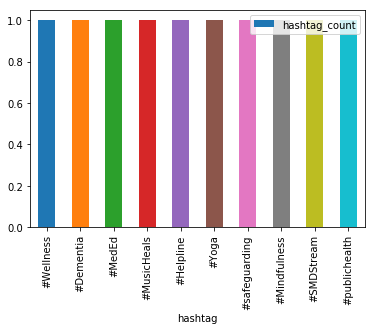

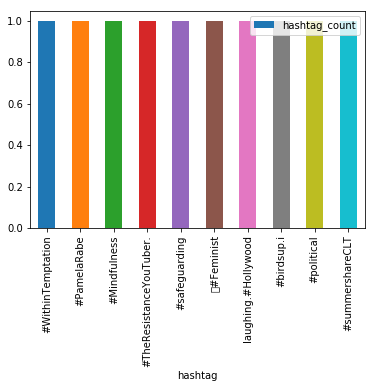

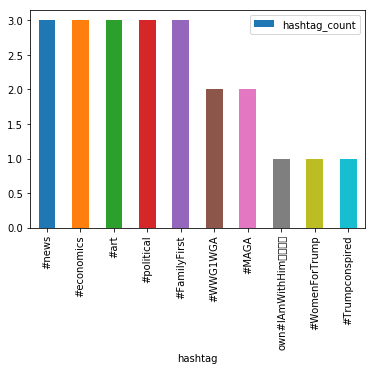

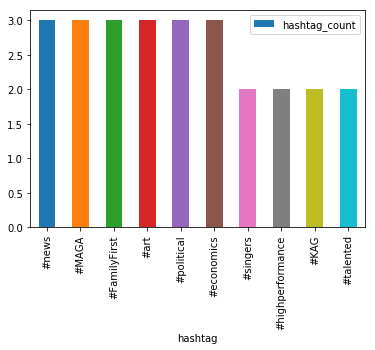

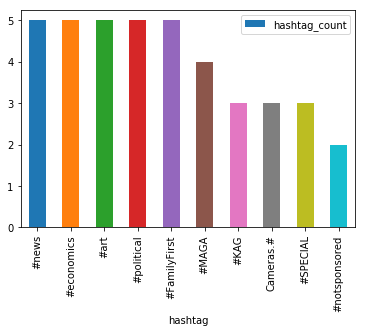

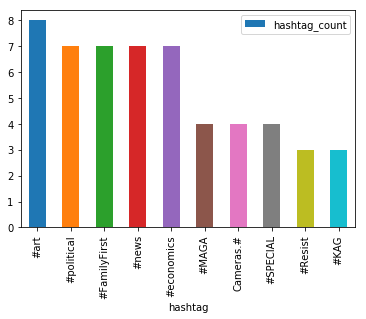

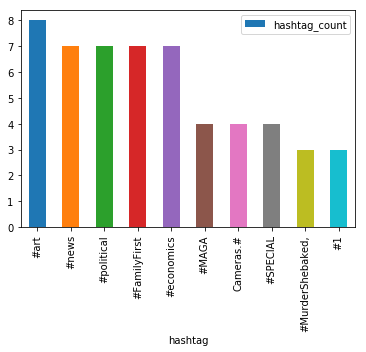

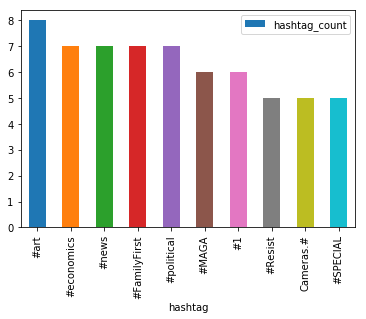

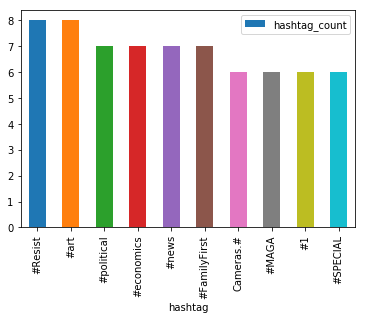

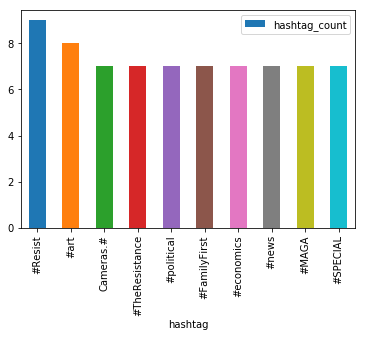

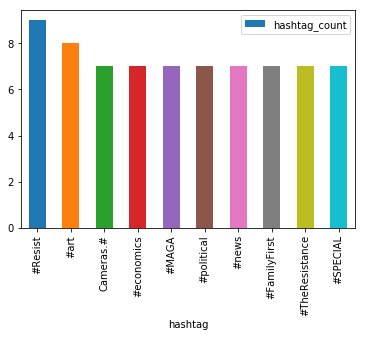

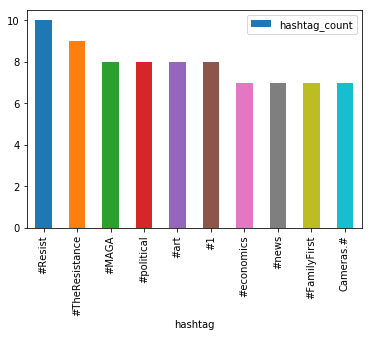

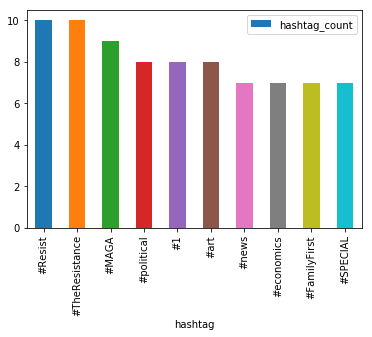

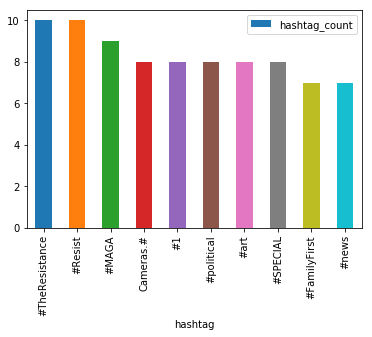

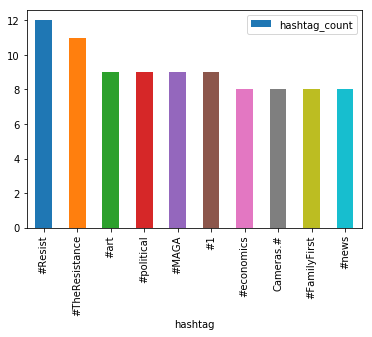

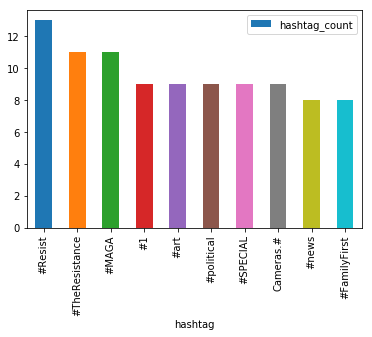

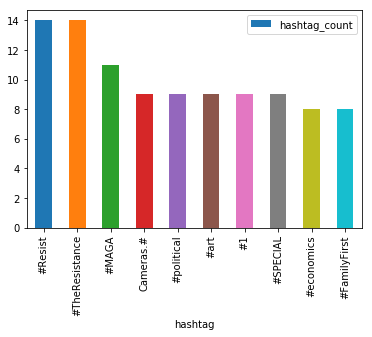

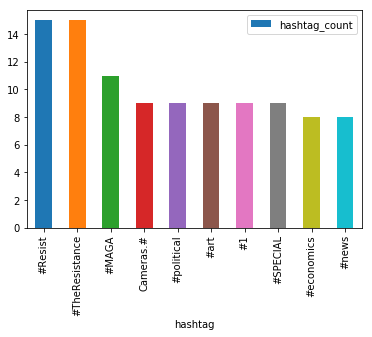

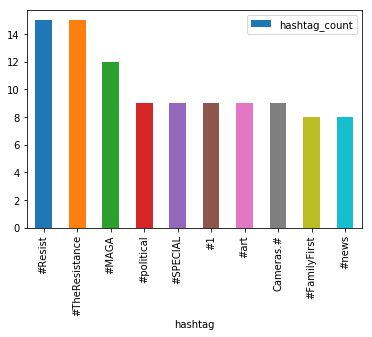

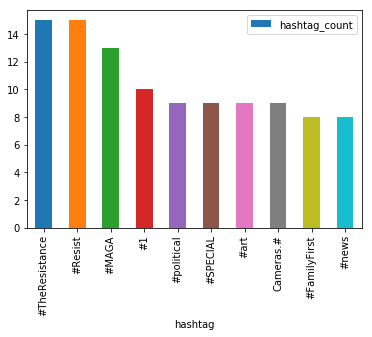

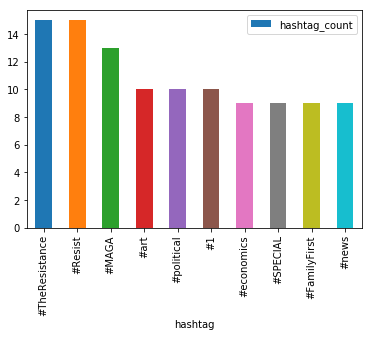

In [6]:
words = lines.flatMap(lambda line: line.split(" "))
hashtag = words.filter(lambda w: '#' in w).map(lambda x: (x, 1))
all_tags = hashtag.updateStateByKey(tags_counter)
all_tags.foreachRDD(tag_process)

ssc.start()  
ssc.awaitTermination() # Wait for the process to terminate

In [7]:
ssc.stop()